In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pprint import pprint
import spacy
from spacy.tokenizer import _get_regex_pattern
import nltk
from nltk.corpus import stopwords
import re
from spacy.matcher import Matcher
import spacy
from spacymoji import Emoji
import emoji
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.feature_extraction.text import CountVectorizer

## Tinder Swindler 100k Tweets

In [20]:
# load the dataset
file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [21]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [22]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [23]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [24]:
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [25]:
df = df[df.is_retweet != True]

In [26]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [27]:
df_sample = df.sample(10000)

### Load Spacy and init stop words

In [28]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("emoji", first=True)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


In [172]:
# extend stop words if needed
stop_words.extend(['\n', "\n\n",'hi','\n','\n\n', '&amp;', ' ', '.','…','…', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@'])

In [173]:
no_stop_words = [
    'not'
]

for w in no_stop_words:
    nlp.vocab[w].is_stop = False

#### Create docs via spacy
Follow along [this](https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a) guide for more details about each single step

In [31]:
# custom extended abbreviations
custom_abbreviations = {"bdrm": "bedroom"}

def normalize(text):
    # choosing BrE variety here since majority of posts are from the UK
        try:
            return ' '.join(normalise(text, variety="BrE", user_abbrevs=custom_abbreviations, verbose=False))
        except:
            return text

In [32]:
df_sample.text.apply(normalize)

33109    @_ItsMarisWorld_ “set it up” is just so so goo...
66592    This woman was taking out loans to give a bill...
40416    14/02/2022 ON ALL DSP's❗❤🔥\n\nKindly pre-save:...
5138                       @reallysamreed Sam the Swindler
21540                 Let me watch lo Tinder Swindler wenu
                               ...                        
66398    Lmao after God fear men!! 😭😭😭😭😭 I’m not even d...
8898                   White women... wyd? #tinderswindler
12396    @castlelitesa My Mom said alcohol is your enem...
58258    What do I want as a #ValentinesDay gift?\nI ju...
17124    Simon being dedicated to the game and wanting ...
Name: text, Length: 10000, dtype: object

In [33]:
# create docs list with nlp
docs = [d for d in nlp.pipe(df_sample.text, n_process=6)]

In [34]:
def remove_stop_words(doc):
    return [t for t in doc if not t.is_stop]

In [35]:
# python based removal
def remove_punct(doc):
    return [t for t in doc if t.text not in string.punctuation]

In [36]:
def remove_hashtag(doc):
    return [t for t in doc if not t.text.startswith('#')]

In [37]:
def remove_annotations(doc):
    return [t for t in doc if not t.text.startswith('@')]

In [38]:
def remove_linebreaks(doc):
    return [t for t in doc if not "\n" in t.text]

In [39]:
def lemmatize(doc):
    return ' '.join([t.lemma_ for t in doc])

In [40]:
def lemmatize_token(doc):
    return [t.lemma_ for t in doc]

In [41]:
def preprocess_text(doc, keep_token):
        removed_punct = remove_punct(doc)
        removed_stop_words = remove_stop_words(removed_punct)
        removed_hashtag = remove_hashtag(removed_stop_words)
        removed_annotations = remove_annotations(removed_hashtag)
        removed_linebreaks = remove_linebreaks(removed_annotations)
        if keep_token:
                return lemmatize_token(removed_linebreaks)
        else:
                return lemmatize(removed_linebreaks)

In [42]:
pre_proccesed_texts = [preprocess_text(doc, False) for doc in docs]

In [43]:
pre_proccesed_texts[0]

'" set " good watch " secret " tinder swindler doc'

In [44]:
pre_proccesed_docs = [preprocess_text(doc, True) for doc in docs]

### Get Hashtags and Emoji

In [45]:
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

In [46]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [47]:
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

top_15_hashtags = counter.most_common(15)

In [48]:
df_hashtags = pd.DataFrame.from_records(top_15_hashtags, columns =['hashtag', 'count'])

In [49]:
df_hashtags

,hashtag,count
0,tinderswindler,2015
1,TheTinderSwindler,1441
2,TinderSwindler,324
3,Netflix,82
4,thetinderswindler,31
5,simonleviev,27
6,TindlerSwindler,18
7,netflix,12
8,Tinderswindler,9
9,Tinder,9


In [50]:
def getEmoji(doc):
    emojis = set()
    if doc._.has_emoji:
        for emoji in doc._.emoji:
                emojis.add((emoji[0],emoji[2])) 

    return emojis

In [51]:
# create list of emojis
emojis = [item for sublist in list(getEmoji(doc) for doc in docs) for item in sublist]

In [52]:
counter = Counter()

for emoji in emojis:
    counter[emoji] += 1

top_15_emoji = (counter.most_common(15))

In [53]:
top_15_emoji

[(('😂', 'face with tears of joy'), 685),
 (('😭', 'loudly crying face'), 401),
 (('🤣', 'rolling on the floor laughing'), 299),
 (('🤯', 'exploding head'), 150),
 (('💀', 'skull'), 106),
 (('😳', 'flushed face'), 97),
 (('😩', 'weary face'), 93),
 (('🥴', 'woozy face'), 54),
 (('👀', 'eyes'), 51),
 (('😅', 'grinning face with sweat'), 50),
 (('😱', 'face screaming in fear'), 41),
 (('🚩', 'triangular flag'), 38),
 (('🤔', 'thinking face'), 33),
 (('🔥', 'fire'), 31),
 (('🥺', 'pleading face'), 28)]

In [54]:
flatted_emojis = []

for emoji in top_15_emoji:
    flatted_emoji = []
    for entry in emoji:
        if hasattr(entry, '__iter__'):
            for i in entry:
                flatted_emoji.append(i)
        else:
            flatted_emoji.append(entry)
    flatted_emojis.append(flatted_emoji)

print(flatted_emojis)
    
   


[['😂', 'face with tears of joy', 685], ['😭', 'loudly crying face', 401], ['🤣', 'rolling on the floor laughing', 299], ['🤯', 'exploding head', 150], ['💀', 'skull', 106], ['😳', 'flushed face', 97], ['😩', 'weary face', 93], ['🥴', 'woozy face', 54], ['👀', 'eyes', 51], ['😅', 'grinning face with sweat', 50], ['😱', 'face screaming in fear', 41], ['🚩', 'triangular flag', 38], ['🤔', 'thinking face', 33], ['🔥', 'fire', 31], ['🥺', 'pleading face', 28]]


In [55]:
# create DataFrame using data
df_emoji = pd.DataFrame.from_records(flatted_emojis, columns =['emoji',"desc", 'count'])

In [56]:
df_emoji

,emoji,desc,count
0,😂,face with tears of joy,685
1,😭,loudly crying face,401
2,🤣,rolling on the floor laughing,299
3,🤯,exploding head,150
4,💀,skull,106
5,😳,flushed face,97
6,😩,weary face,93
7,🥴,woozy face,54
8,👀,eyes,51
9,😅,grinning face with sweat,50


### First explorative Analysis

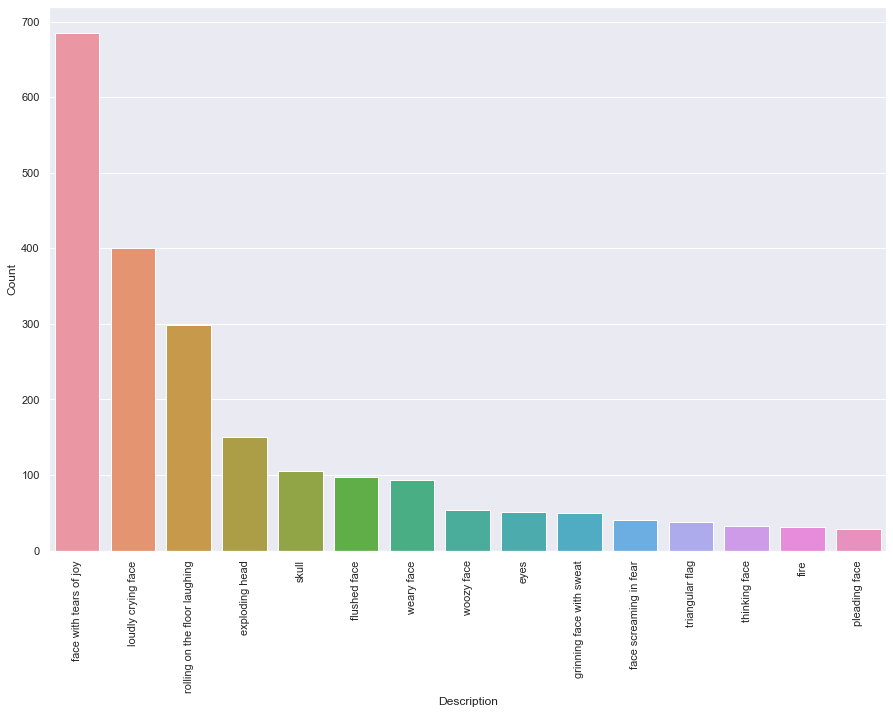

In [59]:
from pathlib import Path
import matplotlib as mpl

plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="desc",y="count", data=df_emoji)
ax.set_xlabel("Description")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


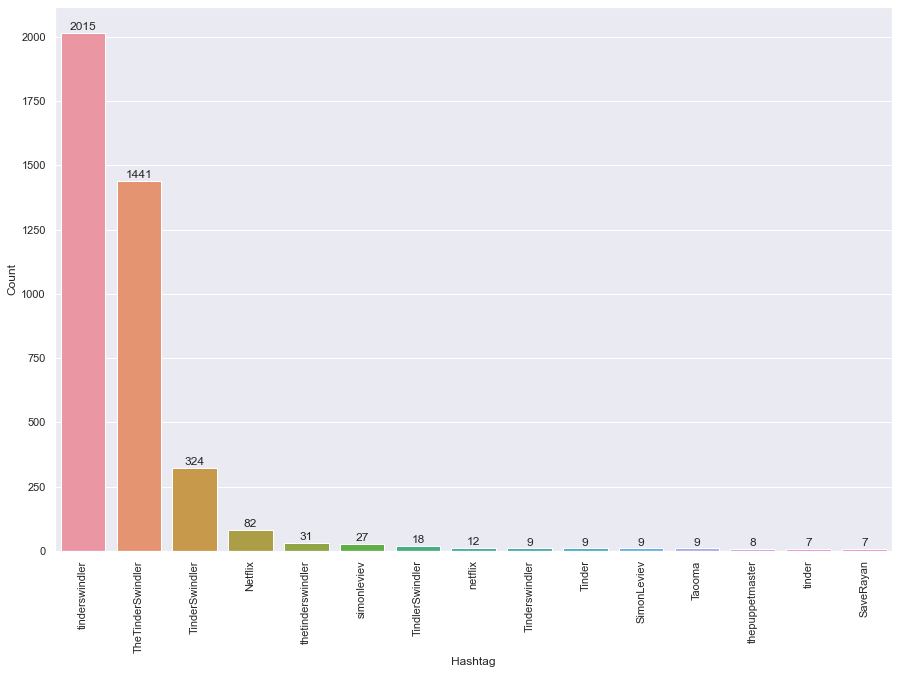

In [60]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="hashtag",y="count", data=df_hashtags)


for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


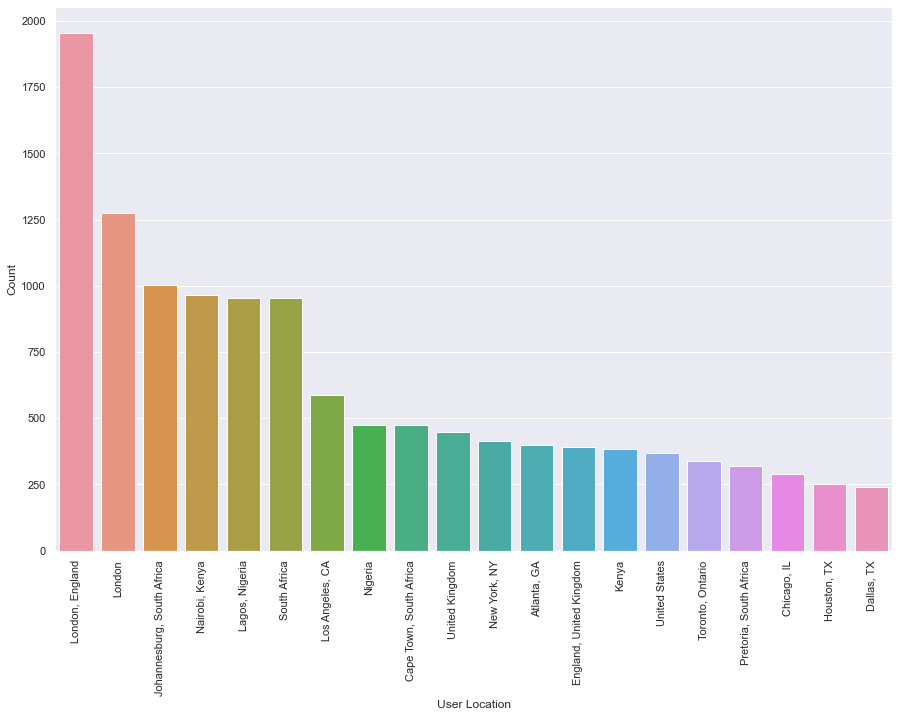

In [61]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_xlabel("User Location")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)

In [62]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [63]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [64]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

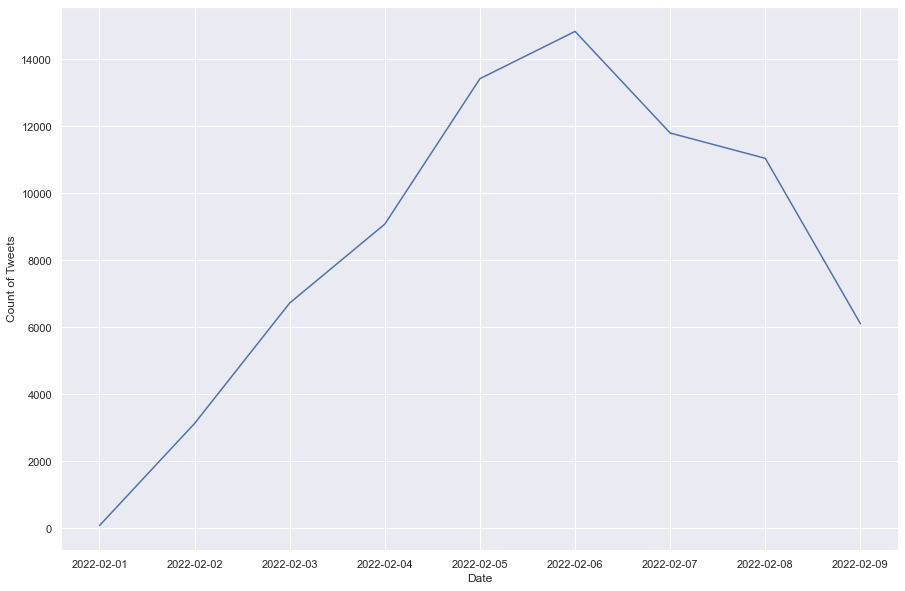

In [65]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

In [66]:
# word count
words = [item for sublist in pre_proccesed_docs for item in sublist]
cv = CountVectorizer().fit(words)
texts_count = cv.transform(words)
sum_words = texts_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


In [67]:
top_20_words = words_freq[:20]

In [68]:
df_word_freq = pd.DataFrame.from_records(top_20_words, columns = ['word', 'count'])

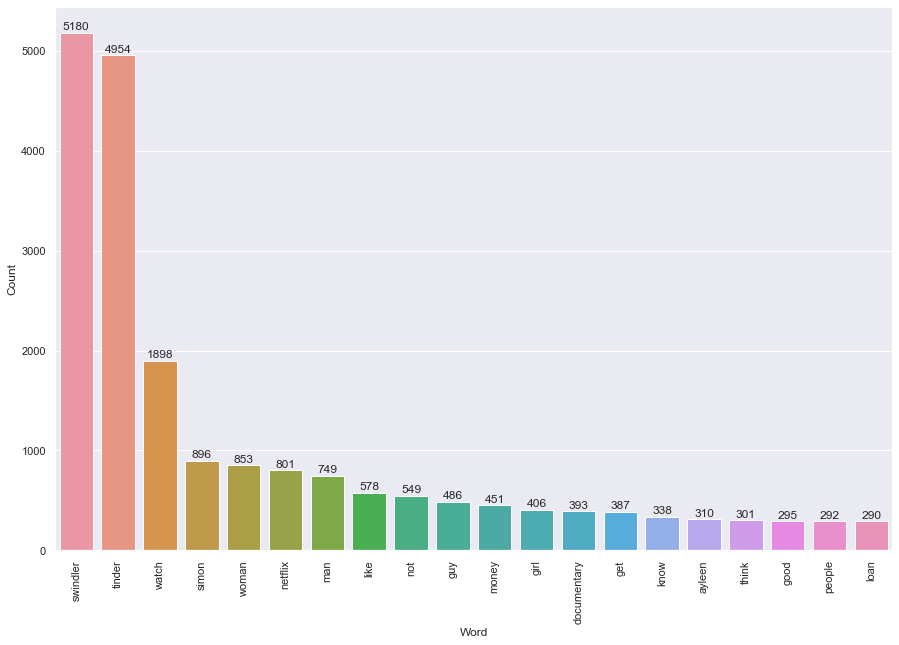

In [69]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="word",y="count", data=df_word_freq)

for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


### Sentiment Analysis

In [81]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [83]:
preprocess_docs_sentiment = [remove_punct(remove_linebreaks(remove_annotations(remove_hashtag(doc)))) for doc in docs]

In [84]:
preprocess_text_sentiment = []
for doc in preprocess_docs_sentiment:
    doc_text = ""
    for word in doc:
        doc_text = doc_text + word.text
        if doc.index(word) +1 < len(doc):
            doc_text = doc_text + " "
    preprocess_text_sentiment.append(doc_text)

In [85]:
preprocess_text_sentiment[:5]

['“ set it up ” is just so so good i ’m watching “ can you keep a secret ” after the tinder swindler doc',
 'This woman was taking out loans to give a billionaire cash and all he ever did for her was buy her flowers Shuuuu',
 "14/02/2022 ON ALL DSP 's ❗ ❤ 🔥 Kindly pre-save:",
 'Sam the Swindler',
 'Let me watch lo Tinder Swindler wenu']

In [86]:
df_preprocessed_text = pd.DataFrame(preprocess_text_sentiment, columns=['text'])

In [87]:
df_preprocessed_text[['polarity', 'subjectivity']] = df_preprocessed_text['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [88]:
for index, row in df_preprocessed_text['text'].items():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_preprocessed_text.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_preprocessed_text.loc[index, 'sentiment'] = "positive"
    else:
        df_preprocessed_text.loc[index, 'sentiment'] = "neutral"
    df_preprocessed_text.loc[index, 'neg'] = neg
    df_preprocessed_text.loc[index, 'neu'] = neu
    df_preprocessed_text.loc[index, 'pos'] = pos
    df_preprocessed_text.loc[index, 'compound'] = comp

In [89]:
df_preprocessed_text.head()

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,“ set it up ” is just so so good i ’m watching...,0.15,0.65,positive,0.000,0.854,0.146,0.6236
1,This woman was taking out loans to give a bill...,0.00,0.00,neutral,0.000,1.000,0.000,0.0000
2,14/02/2022 ON ALL DSP 's ❗ ❤ 🔥 Kindly pre-save:,0.60,0.90,positive,0.128,0.479,0.394,0.7184
3,Sam the Swindler,0.00,0.00,neutral,0.000,1.000,0.000,0.0000
4,Let me watch lo Tinder Swindler wenu,0.00,0.00,neutral,0.000,1.000,0.000,0.0000


In [90]:
df_preprocessed_text_negative = df_preprocessed_text[df_preprocessed_text["sentiment"]=="negative"]
df_preprocessed_text_positive = df_preprocessed_text[df_preprocessed_text["sentiment"]=="positive"]
df_preprocessed_text_neutral = df_preprocessed_text[df_preprocessed_text["sentiment"]=="neutral"]

In [91]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
df_sentiment = count_values_in_column(df_preprocessed_text,"sentiment")

print(df_sentiment)

          Total  Percentage
positive   3653       36.53
negative   3276       32.76
neutral    3071       30.71


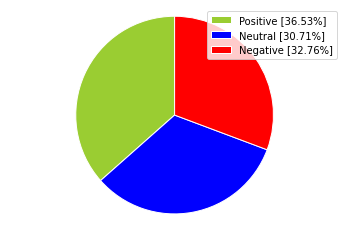

In [92]:
labels = ['Positive ['+str(df_sentiment['Percentage']['positive'])+'%]' , 'Neutral ['+str(df_sentiment['Percentage']['neutral'])+'%]','Negative ['+str(df_sentiment['Percentage']['negative'])+'%]']
sizes = df_sentiment['Percentage']
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.axis('equal')
plt.show()

### LDA

#### Prepare raw text data for lda

In [174]:
# prepare text for lda model
df_lda = pd.DataFrame(df_sample['text'], columns=["text"])
# Remove punctuation
df_lda['text_processed_cleaned'] = df_lda['text'].map(lambda x: re.sub('[,\.!?\n]', '', x))
# Remove hashtags
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.sub('#\w+|\w+-\w+', '', x))
# Remove annotations
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.sub('@\w+|\w+-\w+', '', x))
# Remove emojis
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: "".join([c for c in x if c not in emoji.UNICODE_EMOJI]))
# Remove linebreaks
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: x.replace('\n', ' '))
# Convert the titles to lowercase
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: x.lower())
# Print out the first rows of df_lda
df_lda.head()

,text,text_processed_cleaned
33109,@_ItsMarisWorld_ “set it up” is just so so goo...,“set it up” is just so so good i’m watching “...
66592,This woman was taking out loans to give a bill...,this woman was taking out loans to give a bill...
40416,14/02/2022 ON ALL DSP's❗❤🔥\n\nKindly pre-save:...,14/02/2022 on all dsp'skindly : …
5138,@reallysamreed Sam the Swindler,sam the swindler
21540,Let me watch lo Tinder Swindler wenu,let me watch lo tinder swindler wenu


#### Tokenize text

In [175]:

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df_lda.text_processed_cleaned.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:2][1][:30])

['this', 'woman', 'was', 'taking', 'out', 'loans', 'to', 'give', 'billionaire', 'cash', 'and', 'all', 'he', 'ever', 'did', 'for', 'her', 'was', 'buy', 'her', 'flowersshuuuu']


#### Buil bigrams and trigrams models

In [178]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

In [179]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [180]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['set', 'good', 'watch', 'keep', 'secret', 'tinder', 'swindler']]


#### Data Transformation: Corpus and Dictionary

In [181]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [187]:
num_topics = 10

In [195]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [184]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"swindler" + 0.025*"tinder" + 0.012*"still" + 0.010*"think" + '
  '0.010*"money" + 0.008*"victim" + 0.008*"get" + 0.007*"ask" + 0.007*"make" + '
  '0.007*"people"'),
 (1,
  '0.154*"tinder" + 0.139*"swindler" + 0.031*"watch" + 0.019*"woman" + '
  '0.016*"man" + 0.012*"go" + 0.011*"say" + 0.008*"see" + 0.008*"documentary" '
  '+ 0.007*"story"'),
 (2,
  '0.087*"swindler" + 0.083*"tinder" + 0.024*"watch" + 0.015*"girl" + '
  '0.014*"documentary" + 0.013*"give" + 0.012*"get" + 0.010*"netflix" + '
  '0.010*"feel" + 0.010*"guy"'),
 (3,
  '0.076*"tinder" + 0.074*"swindler" + 0.047*"watch" + 0.020*"woman" + '
  '0.012*"guy" + 0.012*"get" + 0.010*"need" + 0.009*"money" + 0.008*"know" + '
  '0.007*"still"'),
 (4,
  '0.094*"tinder" + 0.090*"swindler" + 0.039*"watch" + 0.026*"woman" + '
  '0.014*"go" + 0.009*"really" + 0.009*"see" + 0.009*"way" + 0.009*"man" + '
  '0.008*"thing"'),
 (5,
  '0.022*"watch" + 0.020*"tinder" + 0.019*"swindler" + 0.017*"woman" + '
  '0.015*"man" + 0.015*"ta

In [196]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35432342607215606


In [ ]:
from gensim import models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10) 
                                          
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

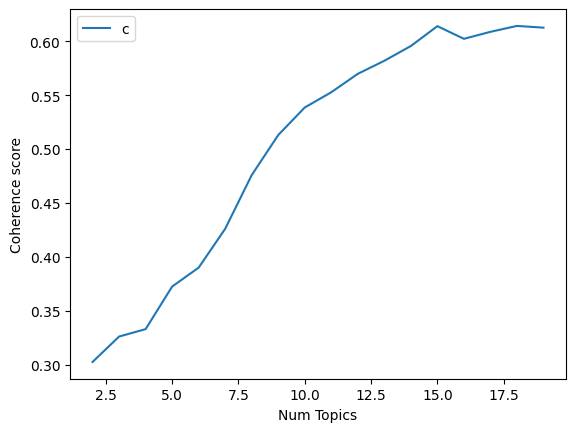

Num Topics = 2  has Coherence Value of 0.3026
Num Topics = 3  has Coherence Value of 0.3261
Num Topics = 4  has Coherence Value of 0.333
Num Topics = 5  has Coherence Value of 0.3725
Num Topics = 6  has Coherence Value of 0.39
Num Topics = 7  has Coherence Value of 0.4261
Num Topics = 8  has Coherence Value of 0.4758
Num Topics = 9  has Coherence Value of 0.513
Num Topics = 10  has Coherence Value of 0.5385
Num Topics = 11  has Coherence Value of 0.5527
Num Topics = 12  has Coherence Value of 0.5698
Num Topics = 13  has Coherence Value of 0.5819
Num Topics = 14  has Coherence Value of 0.5956
Num Topics = 15  has Coherence Value of 0.614
Num Topics = 16  has Coherence Value of 0.6022
Num Topics = 17  has Coherence Value of 0.6087
Num Topics = 18  has Coherence Value of 0.6142
Num Topics = 19  has Coherence Value of 0.6126


In [202]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))